<a href="https://colab.research.google.com/github/marta4cod/NNProject2/blob/main/NN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install datasets

In [15]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.1 MB/s eta 0:00:00


In [17]:
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
import numpy as np
import string, re

import evaluate

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    BertConfig,
    BertForQuestionAnswering
)
from google.colab import files


In [3]:
###############################################################################
# CONFIG
###############################################################################
TEACHER_MODEL_NAME = "bert-large-uncased-whole-word-masking-finetuned-squad"
MAX_LENGTH = 384
STRIDE = 128
BATCH_SIZE = 8
EPOCHS = 6  # Increase for better results
LEARNING_RATE = 1e-5

# Distillation hyperparams
ALPHA = 0.8        # Weight of soft (teacher) loss
TEMPERATURE = 2.0  # Temperature for soft logits
MAX_ANSWER_LENGTH = 10  # Adjust this number based on typical answer sizes

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

Using device: cuda


In [4]:
#########################################
# Introducing seeds to minimise variability in F1 and EM scores

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [5]:
#########################################
# Function to measure time and memory

def benchmark_inference(model, dataloader, device, description="Model"):
    import time
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

    model.eval()
    start_time = time.time()

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            if 'token_type_ids' in batch:
                token_type_ids = batch['token_type_ids'].to(device)
            else:
                token_type_ids = None

            _ = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

    end_time = time.time()

    total_time = end_time - start_time
    max_memory = torch.cuda.max_memory_allocated() / 1e6  # Convert to MB

    print(f"\n🔹 {description} Inference Benchmark:")
    print(f"   Inference Time: {total_time:.2f} seconds")
    print(f"   Max GPU Memory Used: {max_memory:.2f} MB")

    return total_time, max_memory


In [6]:
###############################################################################
# 1) DATA LOADING & PREPROCESSING WITH CHUNKING
###############################################################################

# load squad Dataset
raw_squad = load_dataset("squad")

# For demonstration, we'll use the full training set or a subset
#train_data = raw_squad["train"]
#val_data = raw_squad["validation"].select(range(1000))

train_data = raw_squad["train"].select(range(5000))     # 5000 samples for training
val_data   = raw_squad["validation"].select(range(1000))  # 1000 samples for validation
tokenizer = AutoTokenizer.from_pretrained(TEACHER_MODEL_NAME, use_fast=True)

#### Processing function with Sliding Window ####
def preprocess_function(examples):
    questions = examples["question"]
    contexts = examples["context"]
    answers = examples["answers"]

    encoding = tokenizer(
        questions,
        contexts,
        max_length=384,
        stride=128,
        padding="max_length",
        truncation="only_second",
        return_overflowing_tokens=True,
        return_offsets_mapping=True
    )

    sample_mapping = encoding["overflow_to_sample_mapping"]
    offset_mapping = encoding["offset_mapping"]

    start_positions = []
    end_positions = []

    for i, offsets in enumerate(offset_mapping):
        sample_index = sample_mapping[i]
        answer = answers[sample_index]
        if len(answer["answer_start"]) == 0:
            start_positions.append(0)
            end_positions.append(0)
            continue

        start_char = answer["answer_start"][0]
        end_char = start_char + len(answer["text"][0])

        token_start = 0
        token_end = len(offsets) - 1

        for idx, (start, end) in enumerate(offsets):
            if start <= start_char < end:
                token_start = idx
            if start < end_char <= end:
                token_end = idx
                break

        start_positions.append(token_start)
        end_positions.append(token_end)

    encoding["start_positions"] = start_positions
    encoding["end_positions"] = end_positions
    encoding.pop("offset_mapping")

    return encoding

# Apply preprocessing
train_processed = train_data.map(preprocess_function, batched=True, remove_columns=train_data.column_names)
val_processed   = val_data.map(preprocess_function, batched=True, remove_columns=val_data.column_names)

# Convert to PyTorch Tensors
train_processed.set_format(type="torch")
val_processed.set_format(type="torch")

# Create DataLoaders
train_loader = DataLoader(train_processed, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_processed, batch_size=BATCH_SIZE, shuffle=False)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
###############################################################################

# load squad Dataset
raw_squad = load_dataset("squad")

# For demonstration, we'll use the full training set or a subset
#train_data = raw_squad["train"]
#val_data = raw_squad["validation"].select(range(1000))

train_data = raw_squad["train"].select(range(5000))     # 500 samples for training
val_data   = raw_squad["validation"].select(range(1000))  # 100 samples for validation
tokenizer = AutoTokenizer.from_pretrained(TEACHER_MODEL_NAME, use_fast=True)

def preprocess_function(examples):
    questions = examples["question"]
    contexts = examples["context"]
    answers = examples["answers"]

    encoding = tokenizer(
        questions,
        contexts,
        max_length=MAX_LENGTH,
        stride=STRIDE,
        padding="max_length",
        truncation="only_second",
        return_overflowing_tokens=True,
        return_offsets_mapping=True
    )

    sample_mapping = encoding["overflow_to_sample_mapping"]
    offset_mapping = encoding["offset_mapping"]
    input_ids_batch = encoding["input_ids"]

    start_positions = []
    end_positions = []

    for i, offsets in enumerate(offset_mapping):
        input_ids = input_ids_batch[i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        sample_index = sample_mapping[i]
        answer = answers[sample_index]

        if len(answer["answer_start"]) == 0:
            start_positions.append(cls_index)
            end_positions.append(cls_index)
            continue

        start_char = answer["answer_start"][0]
        end_char = start_char + len(answer["text"][0])

        token_start_index = 0
        token_end_index = len(offsets) - 1

        while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
            token_start_index += 1
        while token_end_index >= 0 and offsets[token_end_index][1] >= end_char:
            token_end_index -= 1

        start_positions.append(token_start_index - 1)
        end_positions.append(token_end_index + 1)

    encoding["start_positions"] = start_positions
    encoding["end_positions"] = end_positions
    encoding.pop("offset_mapping")

    return encoding


# Apply preprocessing
train_processed = train_data.map(preprocess_function, batched=True, remove_columns=train_data.column_names)
val_processed   = val_data.map(preprocess_function, batched=True, remove_columns=val_data.column_names)

# Convert to PyTorch Tensors
train_processed.set_format(type="torch")
val_processed.set_format(type="torch")

# Create DataLoaders
train_loader = DataLoader(train_processed, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_processed, batch_size=BATCH_SIZE, shuffle=False)



In [8]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()


In [9]:
###############################################################################
# 2) TEACHER MODEL INFERENCE (collect teacher logits)
###############################################################################
teacher_model = AutoModelForQuestionAnswering.from_pretrained(TEACHER_MODEL_NAME).to(DEVICE)
teacher_model.eval()

#evaluating model
benchmark_inference(teacher_model, val_loader, DEVICE, description="Teacher Model with Chunking")

teacher_start_logits_list = []
teacher_end_logits_list   = []
gt_start_list = []
gt_end_list   = []
input_tensors = []
count=0
with torch.no_grad():
    for batch in train_loader:
      count+=1
      print("batch", count)

      input_ids = batch['input_ids'].squeeze(1).to(DEVICE)
      attention_mask = batch['attention_mask'].squeeze(1).to(DEVICE)

      # batch can have 4 or 5 tensors depending on token_type_ids existence
      if 'token_type_ids' in batch:
        token_type_ids = batch['token_type_ids'].squeeze(1).to(DEVICE)
      else:
        token_type_ids = None

      start_pos = batch['start_positions'].to(DEVICE)
      end_pos = batch['end_positions'].to(DEVICE)

      outputs = teacher_model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids
      )
      # Collect logits
      teacher_start_logits_list.append(outputs.start_logits.cpu())
      teacher_end_logits_list.append(outputs.end_logits.cpu())

      gt_start_list.append(start_pos.cpu())
      gt_end_list.append(end_pos.cpu())

      # We'll store the CPU tensors of inputs for the student dataset
      if token_type_ids is not None:
          input_tensors.append((input_ids.cpu(), attention_mask.cpu(), token_type_ids.cpu()))
      else:
          # Rare for BERT-based QA to not have token_type_ids, but just in case:
          # We'll store None in place of token_type_ids.
          input_tensors.append((input_ids.cpu(), attention_mask.cpu(), None))

# Concatenate teacher outputs
teacher_start_logits_full = torch.cat(teacher_start_logits_list, dim=0)
teacher_end_logits_full   = torch.cat(teacher_end_logits_list, dim=0)
gt_start_full = torch.cat(gt_start_list, dim=0)
gt_end_full   = torch.cat(gt_end_list, dim=0)

# Flatten input tensors
all_input_ids         = []
all_attention_masks   = []
all_token_type_ids    = []
for i_ids, i_mask, i_type in input_tensors:
    all_input_ids.append(i_ids)
    all_attention_masks.append(i_mask)
    if i_type is not None:
        all_token_type_ids.append(i_type)

all_input_ids = torch.cat(all_input_ids, dim=0)
all_attention_masks = torch.cat(all_attention_masks, dim=0)
if all_token_type_ids is not None and len(all_token_type_ids) > 0:
    all_token_type_ids = torch.cat(all_token_type_ids, dim=0)
else:
    all_token_type_ids = None

print("Teacher logits shapes:")
print("  start_logits:", teacher_start_logits_full.shape)
print("  end_logits:  ", teacher_end_logits_full.shape)
print("Ground truth shapes:", gt_start_full.shape, gt_end_full.shape)

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



🔹 Teacher Model with Chunking Inference Benchmark:
   Inference Time: 16.16 seconds
   Max GPU Memory Used: 1514.11 MB
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
batch 49
batch 50
batch 51
batch 52
batch 53
batch 54
batch 55
batch 56
batch 57
batch 58
batch 59
batch 60
batch 61
batch 62
batch 63
batch 64
batch 65
batch 66
batch 67
batch 68
batch 69
batch 70
batch 71
batch 72
batch 73
batch 74
batch 75
batch 76
batch 77
batch 78
batch 79
batch 80
batch 81
batch 82
batch 83
batch 84
batch 85
batch 86
batch 87
batch 88
batch 89
batch 90
batch 91
batch 92
batch 93
batch 94
batch 95
batch 96
batch 97
batch 98
batch 9

In [10]:

###############################################################################
# 3) DEFINE A SMALLER STUDENT MODEL
###############################################################################
student_config = BertConfig(
    vocab_size=tokenizer.vocab_size,
    hidden_size=384,         # smaller hidden dim
    num_hidden_layers=8,     # fewer layers
    num_attention_heads=8,   # fewer heads
    intermediate_size=384 * 4,
    max_position_embeddings=MAX_LENGTH
)
student_model = BertForQuestionAnswering(student_config).to(DEVICE)

In [11]:
# Evaluation of model size
torch.save(student_model.state_dict(), "student_model_temp.pth")

import os

size_mb = os.path.getsize("student_model_temp.pth") / 1e6
print(f"Student model size: {size_mb:.2f} MB")

os.remove("student_model_temp.pth")

total_params = sum(p.numel() for p in student_model.parameters())
print(f"Total parameters: {total_params:,}")

Student model size: 104.32 MB
Total parameters: 26,065,922


In [12]:
###############################################################################
# 4) DISTILLATION TRAINING
###############################################################################

def softmax_with_temperature(logits, temperature=TEMPERATURE):
    return F.softmax(logits / temperature, dim=-1)

# Prepare teacher soft targets
teacher_start_probs = softmax_with_temperature(teacher_start_logits_full, TEMPERATURE)
teacher_end_probs   = softmax_with_temperature(teacher_end_logits_full, TEMPERATURE)

# Custom Dataset
class DistillationDataset(Dataset):
    def __init__(self, input_ids, attention_mask, token_type_ids,
                 teacher_start_probs, teacher_end_probs,
                 gt_start, gt_end):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.token_type_ids = token_type_ids
        self.teacher_start_probs = teacher_start_probs
        self.teacher_end_probs   = teacher_end_probs
        self.gt_start = gt_start
        self.gt_end   = gt_end

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return (
            self.input_ids[idx],
            self.attention_mask[idx],
            self.token_type_ids[idx] if self.token_type_ids is not None else None,
            self.teacher_start_probs[idx],
            self.teacher_end_probs[idx],
            self.gt_start[idx],
            self.gt_end[idx],
        )

# DataLoader and Optimizer
distill_dataset = DistillationDataset(
    all_input_ids, all_attention_masks, all_token_type_ids,
    teacher_start_probs, teacher_end_probs,
    gt_start_full, gt_end_full
)
distill_loader = DataLoader(distill_dataset, batch_size=BATCH_SIZE, shuffle=True)
optimizer = torch.optim.AdamW(student_model.parameters(), lr=LEARNING_RATE)

# Training Step
def distillation_train_step(batch_data):
    input_ids, attention_mask, token_type_ids, t_start_probs, t_end_probs, gt_start, gt_end = batch_data

    input_ids = input_ids.to(DEVICE)
    attention_mask = attention_mask.to(DEVICE)
    t_start_probs = t_start_probs.to(DEVICE)
    t_end_probs   = t_end_probs.to(DEVICE)
    gt_start = gt_start.to(DEVICE)
    gt_end   = gt_end.to(DEVICE)

    if token_type_ids is not None:
        token_type_ids = token_type_ids.to(DEVICE)

    optimizer.zero_grad()

    outputs = student_model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids
    )
    student_start_logits = outputs.start_logits
    student_end_logits   = outputs.end_logits

    # Ensure targets are within valid range
    seq_len = student_start_logits.shape[1]
    gt_start = torch.clamp(gt_start, min=0, max=seq_len - 1)
    gt_end   = torch.clamp(gt_end, min=0, max=seq_len - 1)

    # Hard loss (ground truth)
    ce_loss_fn = nn.CrossEntropyLoss()
    loss_start_hard = ce_loss_fn(student_start_logits, gt_start)
    loss_end_hard   = ce_loss_fn(student_end_logits,   gt_end)

    hard_loss = 0.5 * (loss_start_hard + loss_end_hard)

    # Soft loss (distillation)
    s_start_probs = softmax_with_temperature(student_start_logits, TEMPERATURE)
    s_end_probs   = softmax_with_temperature(student_end_logits,   TEMPERATURE)

    kl_loss_fn = nn.KLDivLoss(reduction="batchmean")
    start_kl = kl_loss_fn((s_start_probs + 1e-8).log(), t_start_probs)
    end_kl   = kl_loss_fn((s_end_probs + 1e-8).log(),   t_end_probs)
    soft_loss = 0.5 * (start_kl + end_kl)

    loss = ALPHA * soft_loss + (1 - ALPHA) * hard_loss

    if torch.isnan(loss):
        print("NaN detected in loss! Skipping batch.")
        return None, None, None

    loss.backward()
    torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)
    optimizer.step()

    return loss.item(), hard_loss.item(), soft_loss.item()

# Training Loop Example (1 epoch for demo)
for step, batch_data in enumerate(distill_loader):
    loss_val, hard_val, soft_val = distillation_train_step(batch_data)
    if loss_val is not None and step % 100 == 0:
        print(f"Step {step} | Loss: {loss_val:.4f} | Hard: {hard_val:.4f} | Soft: {soft_val:.4f}")


Step 0 | Loss: 4.5397 | Hard: 5.7426 | Soft: 4.2390
Step 100 | Loss: 2.9774 | Hard: 3.0829 | Soft: 2.9510
Step 200 | Loss: 2.8818 | Hard: 2.6470 | Soft: 2.9404
Step 300 | Loss: 2.8514 | Hard: 2.6746 | Soft: 2.8956
Step 400 | Loss: 3.2662 | Hard: 3.3365 | Soft: 3.2486
Step 500 | Loss: 3.0847 | Hard: 2.7250 | Soft: 3.1746
Step 600 | Loss: 2.6560 | Hard: 2.6304 | Soft: 2.6624


In [13]:

def normalize_text(s):
    """Lower text and remove punctuation, articles, and extra whitespace."""
    def remove_articles(txt):
        return re.sub(r'\b(a|an|the)\b', ' ', txt)

    def remove_punc(txt):
        return ''.join(ch for ch in txt if ch not in string.punctuation)

    s = s.lower()
    s = remove_articles(s)
    s = remove_punc(s)
    return ' '.join(s.split())

def compute_exact_match(pred, truth):
    return int(normalize_text(pred) == normalize_text(truth))

def compute_f1(pred, truth):
    pred_tokens = normalize_text(pred).split()
    truth_tokens = normalize_text(truth).split()
    common = set(pred_tokens) & set(truth_tokens)
    if len(common) == 0:
        return 0
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(truth_tokens)
    return 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0


In [26]:
##########################################################################
######### FUNCTION FOR EVALUATION AND PLOTTING ################

# Load the official SQuAD evaluation metric
squad_metric = evaluate.load("squad")

def evaluate_student_model(student_model, val_dataloader, val_data, tokenizer, num_examples_to_save=5):
    predictions = []
    references = []
    offset = 0

    val_contexts = val_data["context"]
    val_questions = val_data["question"]
    val_answers  = val_data["answers"]

    # List to store examples for later display
    example_predictions = []

    student_model.eval()
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            start_pos = batch['start_positions'].to(DEVICE)
            end_pos = batch['end_positions'].to(DEVICE)

            token_type_ids = batch.get('token_type_ids')
            if token_type_ids is not None:
                token_type_ids = token_type_ids.to(DEVICE)

            outputs = student_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )
            start_logits = outputs.start_logits
            end_logits   = outputs.end_logits

            start_indices = torch.argmax(start_logits, dim=1).cpu().numpy()
            end_indices   = torch.argmax(end_logits,   dim=1).cpu().numpy()

            for i in range(len(start_indices)):
                global_idx = offset + i
                if global_idx >= len(val_contexts):
                    continue

                s_ind = start_indices[i]
                e_ind = end_indices[i]
                if e_ind < s_ind:
                    e_ind = s_ind

                # Apply Max Span Length
                MAX_ANSWER_LENGTH = 10
                if (e_ind - s_ind + 1) > MAX_ANSWER_LENGTH:
                    e_ind = s_ind + MAX_ANSWER_LENGTH - 1

                e_ind = min(e_ind, input_ids.shape[1] - 1)

                tokens_ = input_ids[i][s_ind : e_ind+1].cpu().numpy().tolist()
                pred_text = tokenizer.decode(tokens_, skip_special_tokens=True)

                gold_answers = val_answers[global_idx]["text"]

                if len(gold_answers) == 0:
                    reference_texts = [""]
                else:
                    reference_texts = gold_answers

                # Prepare for official SQuAD metric
                predictions.append({
                    "id": str(global_idx),
                    "prediction_text": pred_text
                })

                references.append({
                    "id": str(global_idx),
                    "answers": {"text": reference_texts, "answer_start": [0]*len(reference_texts)}  # start not used here
                })

                # Save sample predictions
                if len(example_predictions) < num_examples_to_save:
                    example_predictions.append({
                        "question": val_questions[global_idx],
                        "predicted": pred_text,
                        "actual": reference_texts
                    })

            offset += len(start_indices)

    # Compute official SQuAD metrics
    results = squad_metric.compute(predictions=predictions, references=references)

    print(f"\nOfficial SQuAD Evaluation:")
    print(f"  Exact Match: {results['exact_match']:.2f}%")
    print(f"  F1 Score:    {results['f1']:.2f}%")

    return results['exact_match'], results['f1'], example_predictions


In [27]:
#########################################################################
########## DISTILATION TRACKING WITH EVALUATION #################

em_tracking = []
f1_tracking = []

for epoch in range(EPOCHS):
    print(f"\n=== EPOCH {epoch+1}/{EPOCHS} ===")
    epoch_losses = []

    for step, batch_data in enumerate(distill_loader):
        loss_val, hard_val, soft_val = distillation_train_step(batch_data)
        epoch_losses.append(loss_val)
        if step % 200 == 0:
            print(f" Step {step} - Distill Loss: {loss_val:.4f} (Hard: {hard_val:.4f}, Soft: {soft_val:.4f})")

    print(f" Average Loss: {np.mean(epoch_losses):.4f}")

    # Evaluate after epoch
    avg_em, avg_f1, samples = evaluate_student_model(student_model, val_loader, val_data, tokenizer)

    print(f"\nEpoch {epoch+1} Validation:")
    print(f"  Exact Match: {avg_em:.2f}%")
    print(f"  F1 Score:    {avg_f1:.2f}%")

    em_tracking.append(avg_em)
    f1_tracking.append(avg_f1)



=== EPOCH 1/6 ===
 Step 0 - Distill Loss: 1.8598 (Hard: 1.8651, Soft: 1.8584)
 Step 200 - Distill Loss: 2.0006 (Hard: 1.9737, Soft: 2.0073)
 Step 400 - Distill Loss: 2.0974 (Hard: 2.0549, Soft: 2.1080)
 Step 600 - Distill Loss: 2.0894 (Hard: 2.0015, Soft: 2.1113)
 Average Loss: 2.1887

Official SQuAD Evaluation:
  Exact Match: 0.10%
  F1 Score:    3.34%

Epoch 1 Validation:
  Exact Match: 0.10%
  F1 Score:    3.34%

=== EPOCH 2/6 ===
 Step 0 - Distill Loss: 1.8521 (Hard: 1.4599, Soft: 1.9501)
 Step 200 - Distill Loss: 2.1376 (Hard: 2.0310, Soft: 2.1642)
 Step 400 - Distill Loss: 2.2149 (Hard: 2.3955, Soft: 2.1698)
 Step 600 - Distill Loss: 2.1025 (Hard: 2.0696, Soft: 2.1107)
 Average Loss: 2.1500

Official SQuAD Evaluation:
  Exact Match: 0.10%
  F1 Score:    3.43%

Epoch 2 Validation:
  Exact Match: 0.10%
  F1 Score:    3.43%

=== EPOCH 3/6 ===
 Step 0 - Distill Loss: 1.9737 (Hard: 1.4996, Soft: 2.0922)
 Step 200 - Distill Loss: 1.7488 (Hard: 1.6916, Soft: 1.7631)
 Step 400 - Distill

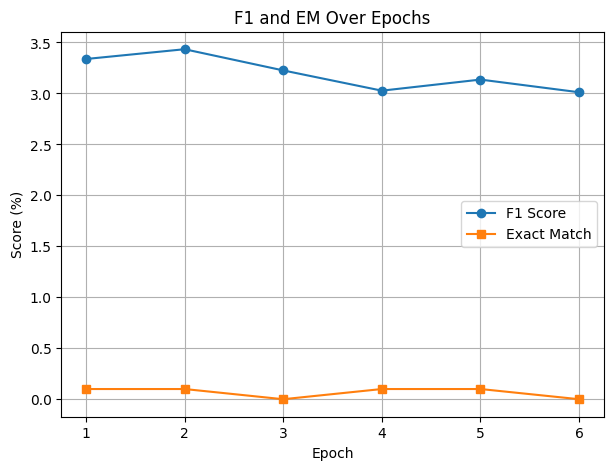

In [28]:
#### Plot F1 and EM Over Epochs #####
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.plot(range(1, EPOCHS+1), f1_tracking, label="F1 Score", marker='o')
plt.plot(range(1, EPOCHS+1), em_tracking, label="Exact Match", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Score (%)")
plt.title("F1 and EM Over Epochs")
plt.legend()
plt.grid(True)

# Save before showing
plt.savefig("f1_em_over_epochs.jpg", dpi=300)
plt.show()

In [ ]:
from google.colab import files
files.download("f1_em_over_epochs.jpg")

In [32]:
import torch

def ask_question(question: str, context: str, model, tokenizer, device=DEVICE): # change device
    """
    Given a question and a context, use the provided model to
    predict the answer span and return the decoded string answer.
    """
    # Encode inputs
    inputs = tokenizer(question, context, return_tensors="pt", max_length= 384, truncation="only_second") # changed here
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    token_type_ids = inputs.get("token_type_ids") # here
    if token_type_ids is not None:
        token_type_ids = token_type_ids.to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
    # extract logits
    start_logits = outputs.start_logits
    end_logits = outputs.end_logits

    # Get predicted start/end token indices
    start_index = torch.argmax(start_logits, dim=1).item()
    end_index = torch.argmax(end_logits, dim=1).item()

    # Ensure the end_index is >= start_index
    if end_index < start_index:
        end_index = start_index

    # Apply max Span Length
    max_span_length = 10
    if (end_index - start_index + 1) > max_span_length:
        end_index = start_index + max_span_length - 1

    # prevent going beyong sequence length
    end_index = min(end_index, len(input_ids[0]) - 1)

    # 4) Decode tokens back to string
    answer_ids = input_ids[0, start_index : end_index+1]
    answer_text = tokenizer.decode(answer_ids, skip_special_tokens=True)

    # Calculate simple confidence score (average of start & end probabilities)
    start_prob = torch.softmax(start_logits, dim=1)[0, start_index].item()
    end_prob   = torch.softmax(end_logits, dim=1)[0, end_index].item()
    confidence = (start_prob + end_prob) / 2

    return answer_text, confidence


# -----------------------------
# Example usage
# -----------------------------

# Suppose you have:
#   teacher_model, student_model (both on the same device, e.g., "cuda" or "cpu")
#   tokenizer (matching your BERT-based QA model)
# Example question + context:
question = "What is the capital of France?"
context = "France is a country in Europe. Its largest city and capital is Paris. It is known for the Eiffel Tower."
#question = "Which country is Middlesex University based?"
#question = "Is Middlesex University a public or an independent university?"
#context = "Middlesex University London is a public research university based in Hendon, northwest London, England."
#question = "Which city is Galatasaray based in?"
#context = "Galatasaray, is a Turkish professional football club based on the European side of the city of Istanbul. It is founded in 1905. The team traditionally play in dark shades of red and yellow at home."

# Evaluate with teacher model
teacher_model.eval()
teacher_answer = ask_question(question, context, teacher_model, tokenizer, device="cuda")
print(f"[Teacher Answer]: {teacher_answer}")

# Evaluate with student model
student_model.eval()
student_answer = ask_question(question, context, student_model, tokenizer, device="cuda")
print(f"[Student Answer]: {student_answer}")

[Teacher Answer]: ('paris', 0.9906919300556183)
[Student Answer]: ('france is a country in europe. its largest city', 0.19713939726352692)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')